In [1]:
# Célula 3: Configuração e Imports
from typing import Literal, TypedDict

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph

# Carrega as variáveis do arquivo .env para o ambiente
load_dotenv()

# Inicializa o LLM. Ele encontrará a OPENAI_API_KEY automaticamente no ambiente.
llm = ChatOpenAI(model="gpt-4o")

In [2]:
# Célula 4: Definição do Estado (State)
class AgentState(TypedDict):
    question: str
    intent: Literal["web_search", "math", "general_chat"]

In [3]:
# Célula 5: Definição dos Nós (Nodes)


def classify_intent(state: AgentState):
    """NÓ 1: Classifica a intenção da pergunta do usuário."""
    question = state["question"]
    prompt = f"""Você é um especialista em classificação de intenções. Classifique a pergunta do usuário em uma das seguintes categorias:
'web_search', 'math', 'general_chat'.

Pergunta: "{question}"
Classificação:"""
    response = llm.invoke(prompt)
    intent = response.content.strip()
    print(f"--- INTENÇÃO CLASSIFICADA: {intent} ---")
    return {"intent": intent}


def web_search(state: AgentState):
    """NÓ 2: Ferramenta (simulada) de busca na web."""
    question = state["question"]
    print(f"--- EXECUTANDO BUSCA NA WEB para: '{question}' ---")
    return {"question": f"A resposta para '{question}' é 42."}


def calculator(state: AgentState):
    """NÓ 3: Ferramenta (simulada) de calculadora."""
    question = state["question"]
    print(f"--- CALCULANDO para: '{question}' ---")
    return {"question": "O resultado do cálculo é 100."}


def general_chat(state: AgentState):
    """NÓ 4: Resposta de chat geral."""
    question = state["question"]
    print(f"--- RESPONDENDO AO CHAT para: '{question}' ---")
    response = llm.invoke(f"Responda de forma amigável: {question}")
    return {"question": response.content}

In [4]:
# Célula 6: Definição da Aresta Condicional (Roteador)
def route_intent(state: AgentState):
    """Verifica a intenção e decide para qual nó ir."""
    intent = state.get("intent")
    if intent == "web_search":
        return "web_search_node"
    if intent == "math":
        return "calculator_node"
    return "general_chat_node"

In [5]:
# Célula 7: Construção e Compilação do Grafo
workflow = StateGraph(AgentState)

workflow.add_node("classify_node", classify_intent)
workflow.add_node("web_search_node", web_search)
workflow.add_node("calculator_node", calculator)
workflow.add_node("general_chat_node", general_chat)

workflow.set_entry_point("classify_node")

workflow.add_conditional_edges(
    "classify_node",
    route_intent,
    {
        "web_search_node": "web_search_node",
        "calculator_node": "calculator_node",
        "general_chat_node": "general_chat_node",
    },
)

workflow.add_edge("web_search_node", END)
workflow.add_edge("calculator_node", END)
workflow.add_edge("general_chat_node", END)

app = workflow.compile()

In [6]:
# Célula 8: Teste 1 - Rota de Busca na Web
inputs = {"question": "Quem é o atual primeiro-ministro do Canadá?"}
result = app.invoke(inputs)

print("\n--- RESULTADO FINAL ---")
print(result["question"])

--- INTENÇÃO CLASSIFICADA: 'web_search' ---
--- RESPONDENDO AO CHAT para: 'Quem é o atual primeiro-ministro do Canadá?' ---

--- RESULTADO FINAL ---
Claro! O atual primeiro-ministro do Canadá é Justin Trudeau. Ele está no cargo desde novembro de 2015, liderando o Partido Liberal. Se precisar de mais informações, sinta-se à vontade para perguntar!


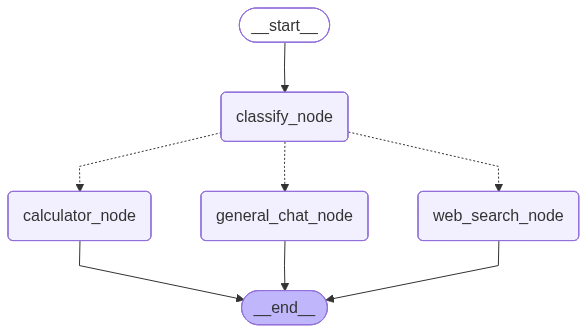

In [7]:
# Importa as ferramentas do Jupyter para exibir imagens
from IPython.display import Image, display

# --- PASSO IMPORTANTE ---
# Certifique-se de que a célula "Célula 7: Construção e Compilação do Grafo",
# que define a variável 'app', já foi executada.

try:
    # 1. Pega a estrutura do grafo a partir do seu app compilado
    # 2. Desenha essa estrutura como uma imagem PNG usando pygraphviz/graphviz
    # 3. Exibe a imagem diretamente na saída da célula

    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))

except NameError:
    print("Erro: A variável 'app' não foi encontrada.")
    print(
        "Por favor, execute a célula 'Construção e Compilação do Grafo' primeiro e tente novamente."
    )
except Exception as e:
    print(f"Ocorreu um erro ao gerar o gráfico: {e}")

In [13]:
# Célula: Código do Grafo com Pydantic (Corrigido)
import operator
from typing import Annotated

from langgraph.graph import StateGraph
from pydantic import BaseModel


# 1. Definimos o estado usando Pydantic.BaseModel
class State(BaseModel):
    msg: Annotated[str, operator.add] = ""


# 2. Criamos o grafo
graph = StateGraph(State)


# 3. Os nós permanecem os mesmos
def step1(state: State) -> dict:
    print("Executando step1")
    return {"msg": "Olá do Pydantic"}


def step2(state: State) -> dict:
    print("Executando step2")
    # CORREÇÃO APLICADA AQUI
    print(f"  -> Estado recebido em step2: {state.model_dump()}")
    return {"msg": " + step2"}


graph.add_node("step1", step1)
graph.add_node("step2", step2)

# 4. As arestas permanecem as mesmas
graph.add_edge("step1", "step2")

# 5. O ponto de entrada e saída permanecem os mesmos
graph.set_entry_point("step1")
graph.set_finish_point("step2")

# 6. Compilamos e rodamos
executor = graph.compile()
result_dict = executor.invoke({})  # O resultado é um dicionário

print("\nResultado final:")

# CORREÇÃO: Crie uma instância do State a partir do dicionário de resultado
final_state = State.model_validate(result_dict)

# Agora você pode usar os métodos do Pydantic
print(final_state.model_dump())

Executando step1
Executando step2
  -> Estado recebido em step2: {'msg': 'Olá do Pydantic'}

Resultado final:
{'msg': 'Olá do Pydantic + step2'}


In [14]:
def nice_message(name: str | None) -> None:
    if name is None:
        print("Hi random person!")
    else:
        print(f"Hi there {name}!")

In [15]:
nice_message(name="Fabio")

Hi there Fabio!


In [16]:
nice_message(name=None)

Hi random person!


In [17]:
nums: list[int] = [1, 2, 3, 4]
squares = list(map(lambda x: x * x, nums))

### State
___

`State (Estado)` é uma `estrutura de dados` compartilhada que mantém as informações atuais ou contexto de toda a aplicação. Em termos simples, é como a memória da aplicação, rastreando as variáveis e dados que os nós podem acessar e modificar durante a execução.

Exemplo Prático: Sistema de Atendimento
Vamos criar um exemplo reproduzível de um sistema simples de atendimento ao cliente:

Pontos-Chave para Entender o State
1. Memória Compartilhada
O State age como um "quadro branco" onde cada nó pode escrever e ler informações:

Nó 1 escreve o nome do cliente
Nó 2 lê esse nome e adiciona a classificação
Nó 3 lê tudo anterior e finaliza o processo

2. Persistência Durante Execução

```python
# No início
state = {"contador": 0, "mensagens": []}

# Após nó 1
state = {"contador": 1, "mensagens": ["Primeiro processamento"]}

# Após nó 2
state = {"contador": 2, "mensagens": ["Primeiro processamento", "Segundo processamento"]}
```
3. Acesso Universal
Todos os nós têm acesso completo ao state - não há isolamento. É como ter variáveis globais que fluem através do grafo.

4. Exemplo do Mundo Real
Imagine uma linha de montagem de pizza:

Estado inicial: {"massa": "crua", "ingredientes": [], "tempo_forno": 0}
Estação 1: Adiciona molho → {"massa": "crua", "ingredientes": ["molho"], ...}
Estação 2: Adiciona queijo → {"massa": "crua", "ingredientes": ["molho", "queijo"], ...}
Estação 3: Assa a pizza → {"massa": "assada", "ingredientes": [...], "tempo_forno": 15}

O State permite que cada estação saiba exatamente o que foi feito anteriormente e adicione sua contribuição ao processo




In [18]:
from typing import TypedDict

from langgraph.graph import END, StateGraph


# 1. DEFINIR O STATE (MEMÓRIA DA APLICAÇÃO)
class AtendimentoState(TypedDict):
    nome_cliente: str
    problema: str
    urgente: bool
    historico_conversa: list[str]
    resolvido: bool


# 2. CRIAR NÓS QUE ACESSAM E MODIFICAM O STATE


def receber_cliente(state: AtendimentoState):
    """Primeiro nó: recebe informações do cliente"""
    # Lê dados do state
    print(f"Atendendo cliente: {state['nome_cliente']}")

    # Modifica o state
    state["historico_conversa"].append(
        f"Cliente {state['nome_cliente']} relatou: {state['problema']}"
    )
    return state


def classificar_urgencia(state: AtendimentoState):
    """Segundo nó: classifica a urgência baseado no problema"""
    # Lê o problema do state
    problema = state["problema"].lower()

    # Modifica o state baseado na análise
    if "não funciona" in problema or "parou" in problema:
        state["urgente"] = True
        state["historico_conversa"].append("⚠️ Caso classificado como URGENTE")
    else:
        state["urgente"] = False
        state["historico_conversa"].append("✓ Caso classificado como normal")

    return state


def resolver_problema(state: AtendimentoState):
    """Terceiro nó: tenta resolver o problema"""
    # Lê múltiplos valores do state
    if state["urgente"]:
        mensagem = f"Prioridade alta para {state['nome_cliente']}"
    else:
        mensagem = f"Atendimento padrão para {state['nome_cliente']}"

    # Modifica o state
    state["historico_conversa"].append(mensagem)
    state["historico_conversa"].append("Solução aplicada com sucesso")
    state["resolvido"] = True

    return state


# 3. CONSTRUIR O GRAFO
workflow = StateGraph(AtendimentoState)

# Adicionar nós
workflow.add_node("recepção", receber_cliente)
workflow.add_node("triagem", classificar_urgencia)
workflow.add_node("resolução", resolver_problema)

# Definir o fluxo
workflow.set_entry_point("recepção")
workflow.add_edge("recepção", "triagem")
workflow.add_edge("triagem", "resolução")
workflow.add_edge("resolução", END)

# Compilar o grafo
app = workflow.compile()

# 4. EXECUTAR COM DIFERENTES ESTADOS INICIAIS

# Exemplo 1: Cliente com problema urgente
print("=== EXEMPLO 1: PROBLEMA URGENTE ===")
estado_inicial_1 = {
    "nome_cliente": "João Silva",
    "problema": "Sistema não funciona",
    "urgente": False,
    "historico_conversa": [],
    "resolvido": False,
}

resultado_1 = app.invoke(estado_inicial_1)
print("\nHistórico do atendimento:")
for msg in resultado_1["historico_conversa"]:
    print(f"  • {msg}")
print(f"\nResolvido: {resultado_1['resolvido']}")

# Exemplo 2: Cliente com problema normal
print("\n\n=== EXEMPLO 2: PROBLEMA NORMAL ===")
estado_inicial_2 = {
    "nome_cliente": "Maria Santos",
    "problema": "Dúvida sobre configuração",
    "urgente": False,
    "historico_conversa": [],
    "resolvido": False,
}

resultado_2 = app.invoke(estado_inicial_2)
print("\nHistórico do atendimento:")
for msg in resultado_2["historico_conversa"]:
    print(f"  • {msg}")
print(f"\nResolvido: {resultado_2['resolvido']}")

# 5. DEMONSTRAR COMO O STATE É COMPARTILHADO
print("\n\n=== ANÁLISE DO STATE ===")
print("O State funciona como memória compartilhada:")
print("1. Cada nó pode LER qualquer campo do state")
print("2. Cada nó pode MODIFICAR qualquer campo do state")
print("3. Mudanças feitas em um nó são visíveis nos próximos")
print("4. O state final contém todo o histórico da execução")

=== EXEMPLO 1: PROBLEMA URGENTE ===
Atendendo cliente: João Silva

Histórico do atendimento:
  • Cliente João Silva relatou: Sistema não funciona
  • ⚠️ Caso classificado como URGENTE
  • Prioridade alta para João Silva
  • Solução aplicada com sucesso

Resolvido: True


=== EXEMPLO 2: PROBLEMA NORMAL ===
Atendendo cliente: Maria Santos

Histórico do atendimento:
  • Cliente Maria Santos relatou: Dúvida sobre configuração
  • ✓ Caso classificado como normal
  • Atendimento padrão para Maria Santos
  • Solução aplicada com sucesso

Resolvido: True


=== ANÁLISE DO STATE ===
O State funciona como memória compartilhada:
1. Cada nó pode LER qualquer campo do state
2. Cada nó pode MODIFICAR qualquer campo do state
3. Mudanças feitas em um nó são visíveis nos próximos
4. O state final contém todo o histórico da execução


## Hello World Agent
___

`StateGraph` framework that helps you design and manage the flow of tasks in your application using a graph

In [19]:
from typing import TypedDict

from langgraph.graph import StateGraph

Lets create a AgentState - shared data structure that keeps track of information as your application runs.

In [ ]:
class AgentState(TypedDict):  # * Our state schema
    message: str


def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting to the message"""
    state["message"] = "Hey " + state["message"] + ", how is your day going?"
    return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("greeting", greeting_node)  # * Add the node to the graph
graph.set_entry_point("greeting")
graph.set_finish_point("greeting")
app = graph.compile()

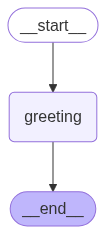

In [22]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
result = app.invoke({"message": "Fabio"})
print(result["message"])

Hey Fabio, how is your day going?


In [24]:
import ast
import sys
from io import StringIO

from langchain.llms import OpenAI

# Configurar sua chave da API OpenAI
# os.environ["OPENAI_API_KEY"] = "sua-chave-aqui"


class AgenteCorrectorCodigo:
    def __init__(self):
        # Inicializar o modelo LLM
        self.llm = OpenAI(temperature=0.1, max_tokens=500)

    def verificar_sintaxe(self, codigo):
        """Verifica se o código está sintaticamente correto"""
        try:
            ast.parse(codigo)
            return True, None
        except SyntaxError as e:
            return False, f"Erro de sintaxe: {e!s}"

    def executar_codigo(self, codigo):
        """Executa o código e verifica se funciona"""
        try:
            # Capturar stdout para evitar prints indesejados
            old_stdout = sys.stdout
            sys.stdout = captured_output = StringIO()

            # Criar namespace local para execução
            local_namespace = {}

            # Executar o código
            exec(codigo, {}, local_namespace)

            # Restaurar stdout
            sys.stdout = old_stdout

            return True, None, local_namespace
        except Exception as e:
            sys.stdout = old_stdout
            return False, f"Erro de execução: {e!s}", None

    def gerar_codigo(self, prompt_usuario, codigo_anterior=None, erro_anterior=None):
        """Gera código usando o LLM"""
        if codigo_anterior is None:
            # Primeira tentativa
            prompt = f"""
Escreva uma função em Python para: {prompt_usuario}

Retorne apenas o código da função, sem explicações adicionais.
"""
        else:
            # Tentativa de correção
            prompt = f"""
Você escreveu este código:
{codigo_anterior}

Mas deu este erro:
{erro_anterior}

Tente corrigir o código. Retorne apenas o código corrigido, sem explicações.
"""

        resposta = self.llm(prompt)
        return resposta.strip()

    def processar_solicitacao(self, prompt_usuario, max_tentativas=3):
        """Processa a solicitação do usuário com loop de correção"""
        print(f"Usuário: {prompt_usuario}")
        print("-" * 50)

        codigo_atual = None
        tentativa = 1

        while tentativa <= max_tentativas:
            print(f"Tentativa {tentativa}:")

            # Passo 2: Gerar código
            if tentativa == 1:
                codigo_atual = self.gerar_codigo(prompt_usuario)
            else:
                codigo_atual = self.gerar_codigo(
                    prompt_usuario, codigo_anterior, erro_anterior
                )

            print("Código gerado:")
            print(codigo_atual)
            print()

            # Passo 3: Verificação
            print("Verificando sintaxe...")
            sintaxe_ok, erro_sintaxe = self.verificar_sintaxe(codigo_atual)

            if not sintaxe_ok:
                print(f"❌ Erro de sintaxe encontrado: {erro_sintaxe}")
                codigo_anterior = codigo_atual
                erro_anterior = erro_sintaxe
                tentativa += 1
                print()
                continue

            print("✅ Sintaxe correta!")

            print("Verificando execução...")
            execucao_ok, erro_execucao, namespace = self.executar_codigo(codigo_atual)

            if not execucao_ok:
                print(f"❌ Erro de execução encontrado: {erro_execucao}")
                codigo_anterior = codigo_atual
                erro_anterior = erro_execucao
                tentativa += 1
                print()
                continue

            print("✅ Execução bem-sucedida!")

            # Passo 4: Decisão - Código está bom!
            print("\n" + "=" * 50)
            print("🎉 CÓDIGO APROVADO!")
            print("=" * 50)
            print("Código final:")
            print(codigo_atual)
            return codigo_atual

        print(
            f"\n❌ Não foi possível corrigir o código após {max_tentativas} tentativas."
        )
        return None


# Exemplo de uso
if __name__ == "__main__":
    # Criar o agente
    agente = AgenteCorrectorCodigo()

    # Exemplo 1: Função simples que deve funcionar
    print("EXEMPLO 1:")
    agente.processar_solicitacao("Escreva uma função em Python que some dois números")

    print("\n" + "=" * 70 + "\n")

    # Exemplo 2: Função mais complexa
    print("EXEMPLO 2:")
    agente.processar_solicitacao(
        "Escreva uma função que calcule o fatorial de um número"
    )

    print("\n" + "=" * 70 + "\n")

    # Exemplo 3: Função com validação
    print("EXEMPLO 3:")
    agente.processar_solicitacao(
        "Escreva uma função que verifique se um número é primo"
    )

/tmp/ipykernel_308822/1609870693.py:15: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  self.llm = OpenAI(temperature=0.1, max_tokens=500)
/tmp/ipykernel_308822/1609870693.py:67: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  resposta = self.llm(prompt)


EXEMPLO 1:
Usuário: Escreva uma função em Python que some dois números
--------------------------------------------------
Tentativa 1:
Código gerado:
def soma(a, b):
    return a + b

Verificando sintaxe...
✅ Sintaxe correta!
Verificando execução...
✅ Execução bem-sucedida!

🎉 CÓDIGO APROVADO!
Código final:
def soma(a, b):
    return a + b


EXEMPLO 2:
Usuário: Escreva uma função que calcule o fatorial de um número
--------------------------------------------------
Tentativa 1:
Código gerado:
def fatorial(n):
    if n == 0:
        return 1
    else:
        return n * fatorial(n-1)

Verificando sintaxe...
✅ Sintaxe correta!
Verificando execução...
✅ Execução bem-sucedida!

🎉 CÓDIGO APROVADO!
Código final:
def fatorial(n):
    if n == 0:
        return 1
    else:
        return n * fatorial(n-1)


EXEMPLO 3:
Usuário: Escreva uma função que verifique se um número é primo
--------------------------------------------------
Tentativa 1:
Código gerado:
def verifica_primo(num):
    if num <

In [25]:
# --- O JEITO MODERNO (LCEL) ---
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# 1. Definir o Prompt
prompt = ChatPromptTemplate.from_template(
    "Crie um nome de prato gourmet usando {ingrediente}."
)

# 2. Definir o LLM
model = ChatOpenAI()

# 3. Definir o Parser de Saída
output_parser = StrOutputParser()

# 4. Criar a "Chain" usando o pipe |
chain = prompt | model | output_parser

# 5. Executar
resultado = chain.invoke({"ingrediente": "frango"})
print(resultado)

Frango ao molho de laranja com crosta de castanhas


In [26]:
from typing import TypedDict

from langgraph.graph import END, StateGraph
from openai import OpenAI

# --- CONFIGURAÇÃO ---
# Certifique-se de que sua chave API está disponível como uma variável de ambiente
# Ex: os.environ["OPENAI_API_KEY"] = "sua_chave_aqui"
client = OpenAI()

In [27]:
def buscar_na_web(query: str) -> str:
    """Uma ferramenta falsa que simula uma busca na web."""
    print(f"--- [Ação] Buscando na web por: '{query}' ---")
    if "polars-express" in query.lower():
        return "Polars-Express é uma nova biblioteca de alto nível construída sobre Polars que simplifica operações comuns de dataframes."
    return "Não foram encontrados resultados de busca relevantes."

In [28]:
class AdvancedTutorState(TypedDict):
    pergunta: str
    nome_agente: str
    papel_agente: str
    instrucoes_agente: str
    # Novos campos para a Fase 2!
    resultado_busca: str  # Guarda o que a busca na web retornou
    caminho_escolhido: str  # Guarda a decisão do "pensador"
    resposta: str

In [29]:
def pensador(state: AdvancedTutorState) -> AdvancedTutorState:
    """Usa o LLM para decidir se precisa buscar na web ou responder diretamente."""
    print("--- [Pensamento] Analisando a pergunta... ---")

    prompt = f"""
    Analisando a seguinte pergunta de um usuário: '{state["pergunta"]}'.
    Eu preciso fazer uma busca na web para obter informações atualizadas ou sobre bibliotecas específicas?
    Responda APENAS com uma única palavra: 'buscar' ou 'responder_direto'.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "system", "content": prompt}],
        temperature=0,
    )

    decisao = response.choices[0].message.content.strip().lower()
    state["caminho_escolhido"] = decisao
    print(f"--- [Decisão] Caminho escolhido: {decisao} ---")

    return state

In [30]:
def buscador(state: AdvancedTutorState) -> AdvancedTutorState:
    """Executa a ferramenta de busca na web."""
    resultado = buscar_na_web(state["pergunta"])
    state["resultado_busca"] = resultado
    return state

In [31]:
def respondendor(state: AdvancedTutorState) -> AdvancedTutorState:
    """Gera a resposta final para o usuário usando o LLM."""
    print("--- [Ação] Gerando a resposta final... ---")

    system_prompt = (
        f"You are {state['nome_agente']}, a {state['papel_agente']}. "
        f"Your instructions: {state['instrucoes_agente']}"
    )

    # Se houver um resultado de busca, o adicionamos ao contexto!
    if state.get("resultado_busca"):
        contexto_adicional = f"\nUse a seguinte informação obtida da web para embasar sua resposta:\n{state['resultado_busca']}"
        system_prompt += contexto_adicional

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": state["pergunta"]},
        ],
    )

    state["resposta"] = response.choices[0].message.content  # type: ignore
    return state

In [32]:
# --- CONSTRUÇÃO DO GRAFO ---
workflow = StateGraph(AdvancedTutorState)

# Adicionar os nós
workflow.add_node("pensador", pensador)
workflow.add_node("buscador", buscador)
workflow.add_node("respondendor", respondendor)

# Definir o ponto de partida
workflow.set_entry_point("pensador")


# Função que o grafo usará para rotear
def decidir_caminho(state: AdvancedTutorState):
    """Lê a decisão do estado e retorna o nome do próximo nó."""
    return state["caminho_escolhido"]


# Aresta Condicional: A "mágica" do LangGraph
workflow.add_conditional_edges(
    "pensador",
    decidir_caminho,
    {"buscar": "buscador", "responder_direto": "respondendor"},
)

# Arestas Lineares
workflow.add_edge("buscador", "respondendor")
workflow.add_edge("respondendor", END)

# Compilar!
app = workflow.compile()

In [33]:
# --- EXECUÇÃO ---
estado_inicial_base = {
    "nome_agente": "Python Tutor",
    "papel_agente": "Programming Assistant",
    "instrucoes_agente": "Explain concepts clearly with code examples.",
    # Inicializar os outros campos
    "resultado_busca": "",
    "caminho_escolhido": "",
    "resposta": "",
}

# TESTE 1: Pergunta geral (deve ir direto para a resposta)
print("--- INICIANDO TESTE 1: PERGUNTA GERAL ---")
pergunta1 = "o que são decorators em python?"
estado1 = {**estado_inicial_base, "pergunta": pergunta1}
resultado1 = app.invoke(estado1)
print("\n--- RESPOSTA FINAL (TESTE 1) ---")
print(resultado1["resposta"])

print("\n" + "=" * 50 + "\n")

# TESTE 2: Pergunta específica (deve acionar a busca)
print("--- INICIANDO TESTE 2: PERGUNTA ESPECÍFICA ---")
pergunta2 = "como usar a nova biblioteca 'polars-express'?"
estado2 = {**estado_inicial_base, "pergunta": pergunta2}
resultado2 = app.invoke(estado2)
print("\n--- RESPOSTA FINAL (TESTE 2) ---")
print(resultado2["resposta"])

--- INICIANDO TESTE 1: PERGUNTA GERAL ---
--- [Pensamento] Analisando a pergunta... ---
--- [Decisão] Caminho escolhido: responder_direto ---
--- [Ação] Gerando a resposta final... ---

--- RESPOSTA FINAL (TESTE 1) ---
Decorators em Python são uma forma conveniente de modificar ou estender o comportamento de funções ou métodos sem alterar seu código original. Eles são frequentemente usados para adicionar funcionalidades, como verificação de permissões, logging, ou medir o tempo de execução de uma função.

### Como Funcionam os Decorators

Um decorator é, na essência, uma função que recebe outra função como argumento e retorna uma nova função que, geralmente, estende ou altera o comportamento da função original.

#### Exemplo Básico de um Decorator

Aqui está um exemplo simples de um decorator que imprime mensagens antes e depois da chamada de uma função:

```python
def meu_decorator(func):
    def wrapper():
        print("Antes da execução da função")
        func()
        print("Dep

In [34]:
# --- PREPARAÇÃO ---
from typing import TypedDict

from langgraph.graph import END, StateGraph
from openai import OpenAI

# Use o gpt-4o-mini, como você mencionou
# Certifique-se que sua chave da OpenAI está nas variáveis de ambiente
client = OpenAI()
MODEL_NAME = "gpt-4o-mini"


# --- ARQUITETURA EM CÓDIGO ---


# 1. O ESTADO: Nossa "ficha" que carrega as informações
class ComplimentState(TypedDict):
    name: str
    topic: str
    compliment: str


# 2. OS NÓS: Nossos "especialistas" que executam as ações


# Nó para a "Ação A": Definir um tópico
def get_topic_node(state: ComplimentState) -> ComplimentState:
    """Define um tópico para o elogio. Em um agente real, isso poderia ser mais complexo."""
    print("--- Nó: Definindo o tópico ---")

    # Para este exercício, o tópico é fixo, baseado no nosso contexto.
    state["topic"] = "aprender LangGraph"
    return state


# Nó para a "Ação B": Gerar o elogio
def generate_compliment_node(state: ComplimentState) -> ComplimentState:
    """Usa o LLM para gerar um elogio criativo baseado no nome e no tópico."""
    print("--- Nó: Gerando o elogio com o LLM ---")

    name = state["name"]
    topic = state["topic"]

    prompt = f"Crie um elogio curto, positivo e encorajador para '{name}' sobre o tópico '{topic}'. Não adicione aspas na sua resposta."

    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.7,
    )

    generated_compliment = response.choices[0].message.content
    state["compliment"] = generated_compliment
    return state


# 3. O GRAFO: O "gerente" que monta o fluxograma


workflow = StateGraph(ComplimentState)

# Adicionar os nós ao nosso workflow
workflow.add_node("topic_suggester", get_topic_node)
workflow.add_node("compliment_generator", generate_compliment_node)

# Definir as conexões (as "setas" do nosso fluxograma)
workflow.set_entry_point("topic_suggester")
workflow.add_edge("topic_suggester", "compliment_generator")
workflow.add_edge("compliment_generator", END)

# Compilar o workflow em uma aplicação
app = workflow.compile()


# --- EXECUÇÃO ---

# A entrada para o nosso agente
input_data = {"name": "Fabio Lima"}

# Invocar o agente
result = app.invoke(input_data)

# Imprimir o resultado final
print("\n--- Elogio Gerado ---")
print(result["compliment"])

--- Nó: Definindo o tópico ---
--- Nó: Gerando o elogio com o LLM ---

--- Elogio Gerado ---
Fabio Lima, sua dedicação em aprender LangGraph é inspiradora! Continue assim, seu esforço e curiosidade certamente o levarão a grandes conquistas. Você está no caminho certo!
